<a href="https://colab.research.google.com/github/Narayan1089/GenshinSolvers/blob/master/YaeNerf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

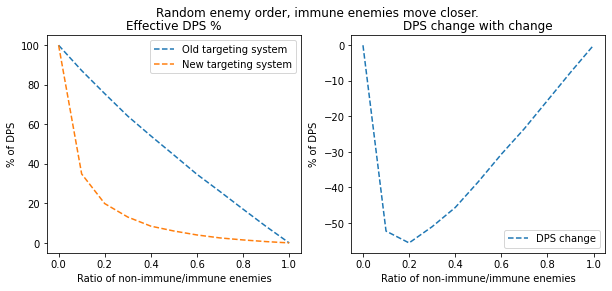

In [1]:
import random
import numpy as np
from matplotlib import pyplot as plt

# creates a random group of enemies, immune enemies in random positions
def createEnemies(amount, immuneAmount, enemyHP):
    enemies = np.zeros(amount)
    while sum(enemies) < immuneAmount:
        immuneEnemy = random.choice([*range(amount)])
        enemies[immuneEnemy] = 1

    for i in range(len(enemies)):
        if enemies[i] == 0:
            enemies[i] = enemyHP
        else:
            enemies[i] = np.inf

    return enemies

# creates a list of enemies, where the immune enemies are at the end of the list
def createEnemiesImmuneLast(amount, immuneAmount, enemyHP):
    enemies = np.zeros(amount-immuneAmount)
    while sum(enemies) < immuneAmount:
        enemies = np.append(enemies, 1)

    for i in range(len(enemies)):
        if enemies[i] == 0:
            enemies[i] = enemyHP
        else:
            enemies[i] = np.inf
    return enemies

# move the immune targets one slot closer to the totems
def moveImmuneCloser(enemies):
    new_enemies = enemies

    for i in range(len(enemies)):
        if enemies[i] != np.inf and i+1 != len(enemies):
            if enemies[i+1] == np.inf:
                new_enemies[i + 1] = enemies[i]
                new_enemies[i] = np.inf

    return new_enemies

# old targeting AI, hits a random enemy
def hitRandom(enemies):
    targets = [*range(len(enemies))]
    target = random.choice(targets)
    #print('Randomly targeted ', target)
    return target

# new targeting AI, always hits the closest enemy
def hitClosest(enemies):
    target = 0
    return target

# check if target is immune or not
def checkHit(enemies, target):
    if enemies[target] != np.inf:
        return True
    else:
        return False

# hit an enemy and make it lose HP, remove from target list if HP = 0
def hitEnemy(enemies, target):
    new_enemies = enemies

    new_enemies[target] = enemies[target]-1
    if new_enemies[target] <= 0:
        new_enemies = np.delete(new_enemies, target)

    return new_enemies

# targeting sim with the old AI
def oldDPSSim(enemies, hits):
    successfulHits = 0

    for i in range(hits):
        random_target = hitRandom(enemies)
        if checkHit(enemies, random_target):
            enemies = hitEnemy(enemies, random_target)
            successfulHits += 1
        if moveCloser:
            if i % hitsToMove == 0:
                enemies = moveImmuneCloser(enemies)

    DPS = successfulHits/hits
    return DPS

# targeting sim with the new AI
def newDPSSim(enemies, hits):
    successfulHits = 0

    for i in range(hits):
        random_target = hitClosest(enemies)
        if checkHit(enemies, random_target):
            enemies = hitEnemy(enemies, random_target)
            successfulHits += 1
        if moveCloser:
            if i % hitsToMove == 0:
                enemies = moveImmuneCloser(enemies)

    DPS = successfulHits/hits
    return DPS

# Parameters for the simulation
amount = 10
hits = 15
enemyHP = 2
iterations = 2000
hitsToMove = 3

# Settings
moveCloser = True
ImmuneFurthest = False

immuneRatios = np.array([*range(amount+1)])/amount
new_avg_DPSs = []
old_avg_DPSs = []
DPS_loss = []

# Run the actual thing
for k in range(amount+1):
    immuneAmount = k

    old_DPSs = []
    new_DPSs = []

    for i in range(iterations):
        if ImmuneFurthest:
            enemies = createEnemiesImmuneLast(amount, immuneAmount, enemyHP)
        else:
            enemies = createEnemies(amount, immuneAmount, enemyHP)
        enemies_2 = enemies.copy()

        old_DPS = oldDPSSim(enemies, hits)
        old_DPSs.append(old_DPS)

        new_DPS = newDPSSim(enemies_2, hits)
        new_DPSs.append(new_DPS)

    old_average_DPS = (np.average(old_DPSs))*100
    new_average_DPS = (np.average(new_DPSs))*100

    #print('Old average DPS %: ', round(old_average_DPS,2))
    #print('New average DPS %: ', round(new_average_DPS,2))

    old_avg_DPSs.append(old_average_DPS)
    new_avg_DPSs.append(new_average_DPS)
    DPS_loss.append(new_average_DPS-old_average_DPS)

# Just some title stuff
title1 = ''
title2 = ''

if ImmuneFurthest:
    title1 = 'Immune enemies furthest, '
else:
    title1 = 'Random enemy order, '

if moveCloser:
    title2 = 'immune enemies move closer.'
else:
    title2 = 'stationary enemies.'

# Plot stuff here
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 4))
fig.suptitle(title1 + title2)
ax1.plot(immuneRatios, old_avg_DPSs, '--', label='Old targeting system')
ax1.plot(immuneRatios, new_avg_DPSs, '--', label='New targeting system')
ax1.legend()
ax1.set_title('Effective DPS %')
ax1.set_xlabel('Ratio of non-immune/immune enemies')
ax1.set_ylabel('% of DPS')

ax2.plot(immuneRatios, DPS_loss, '--', label='DPS change')
ax2.set_xlabel('Ratio of non-immune/immune enemies')
ax2.set_ylabel('% of DPS')
ax2.set_title('DPS change with change')
ax2.legend()

plt.show()